<a href="https://colab.research.google.com/github/VadymBoyko/DS-HW01/blob/main/HW8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Создание нейронной сети

В этом задании мы создадим полносвязную нейронную сеть используя при этом низкоуровневые механизмы tensorflow.

Архитектутра нейросети представлена на следующем рисунке. Как видите, в ней имеется один входной слой, два скрытых, а так же выходной слой. В качестве активационной функции в скрытых слоях будет использоваться сигмоида. На выходном слое мы используем softmax.

Часть кода по созданию сети уже написана, от вас требуется заполнить пропуски в указанных местах.

## Архитектура нейронной сети

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## О датасете MNIST

Данную нейросеть мы будем обучать на датасете MNIST. Этот датасет представляет собой большое количество изображений рукописных цифр размером $28 \times 28$ пикселей. Каждый пиксель принимает значение от 0 до 255.

Как и раньше датасет будет разеделен на обучающую и тестовую выборки. При этом мы выполним нормализацию всех изображений, чтобы значения пикселей находились в промежутке от 0 до 1, разделив яркость каждого пикселя на 255.

Кроме того, архитектура нейронной сети ожидает на вход вектор. В нашем же случае каждый объект выборки представляет собой матрицу. Что же делать? В этом задании мы "растянем" матрицу $28 \times 28$, получив при этом вектор, состоящей из 784 элементов.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Больше информации о датасете можно найти [здесь](http://yann.lecun.com/exdb/mnist/).

In [44]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.metrics import confusion_matrix

In [3]:
num_classes = 10 # общее количество классов, в нашем случае это цифры от 0 до 9
num_features = 784 # количество атрибутов входного вектора 28 * 28 = 784

learning_rate = 0.001 # скорость обучения нейронной сети
training_steps = 3000 # максимальное число эпох
batch_size = 256 # пересчитывать веса сети мы будем не на всей выборке, а на ее случайном подможестве из batch_size элементов
display_step = 100 # каждые 100 итераций мы будем показывать текущее значение функции потерь и точности

n_hidden_1 = 128 # количество нейронов 1-го слоя
n_hidden_2 = 256 # количество нейронов 2-го слоя

In [4]:
from tensorflow.keras.datasets import mnist

# Загружаем датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Преобразуем целочисленные пиксели к типа float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Преобразуем матрицы размером 28x28 пикселей в вектор из 784 элементов
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормализуем значения пикселей
x_train, x_test = x_train / 255., x_test / 255.

# Перемешаем тренировочные данные
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 [==============================] - 0s 0us/step


In [5]:
# Создадим нейронную сеть

class DenseLayer(tf.Module):
    def __init__(self, _in, _out, name=None, activation="relu"):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([_in, _out], stddev=0.05), name="w")
        self.b = tf.Variable(tf.zeros([_out]), name="b")
        self.activation = activation


    def __call__(self, x):
        y_in = tf.matmul(x, self.w) + self.b
        if self.activation == "relu":
            y = tf.nn.relu(y_in)
        if self.activation == "softmax":
            y = tf.nn.softmax(y_in)
        return y


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)

        # Первый слой, состоящий из 128 нейронов
        self.layer_1 = DenseLayer(_in=num_features, _out=n_hidden_1)

        # Второй слой, состоящий из 256 нейронов
        self.layer_2 = DenseLayer(_in=n_hidden_1, _out=n_hidden_2)

        # Выходной слой
        self.layer_3 = DenseLayer(_in=n_hidden_2, _out=10, activation="softmax")


    def __call__(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        return x

    # Помните что для выхода нейронной сети мы применяем к выходу функцию softmax.
    # Делаем мы это для того, чтобы
    # выход нейронной сети принимал значения от 0 до 1 в соответствии с вероятностью
    # принадлежности входного объекта к одному из 10 классов

    # x = # Место для вашего кода
    # return tf.nn.softmax()

In [6]:
# В качестве функции ошибки в данном случае удобно взять кросс-энтропию
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Вычисление кросс-энтропии
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# В качестве метрики качества используем точность
def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.cast(y_true, tf.int64))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32), axis=-1)

In [7]:
# Создадим экзампляр нейронной сети
model = NN(name="mnist")

# Функция обучения нейросети
def train(nn, input_x, output_y):
  # Для подгонки весов сети будем использовать стохастический градиентный спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активация автоматического дифференцирования
  with tf.GradientTape() as g:
    pred = model(input_x)
    loss = cross_entropy(pred, output_y)
    # Создадим оптимизируемый список параметров
    opt_param = model.trainable_variables

    # Вычислим по ним значение градиента
    gradients = g.gradient(loss, opt_param)

    # Модифицируем параметры
    optimizer.apply_gradients(zip(gradients, opt_param))

In [8]:
# Тренировка сети

loss_history = []  # каждые display_step шагов сохраняйте в этом список текущую ошибку нейросети
accuracy_history = [] # каждые display_step шагов сохраняйте в этом список текущую точность нейросети

# В этом цикле мы будем производить обучение нейронной сети
# из тренировочного датасета train_data извлеките случайное подмножество, на котором
# произведется тренировка. Используйте метод take, доступный для тренировочного датасета.
for step, (batch_x, batch_y) in zip(range(training_steps), train_data.take(training_steps)): # Место для вашего кода:
    # Обновляем веса нейронной сети
    train(model, batch_x, batch_y)

    if step % display_step == 0:
        pred = model(batch_x)
        loss=cross_entropy(y_pred=pred, y_true=batch_y)
        loss_history.append(loss)
        accur=accuracy(y_pred=pred, y_true=batch_y)
        accuracy_history.append(accur)
        print(f' step:{step}, loss: {loss}, accuracy: {accur}')
        # Место для вашего кода

 step:0, loss: 580.5259399414062, accuracy: 0.1796875
 step:100, loss: 94.84556579589844, accuracy: 0.8828125
 step:200, loss: 81.85877227783203, accuracy: 0.90625
 step:300, loss: 40.70421600341797, accuracy: 0.953125
 step:400, loss: 48.9058837890625, accuracy: 0.9453125
 step:500, loss: 52.49639892578125, accuracy: 0.93359375
 step:600, loss: 18.821887969970703, accuracy: 0.984375
 step:700, loss: 20.84727668762207, accuracy: 0.9765625
 step:800, loss: 11.047870635986328, accuracy: 0.99609375
 step:900, loss: 27.9031982421875, accuracy: 0.9765625
 step:1000, loss: 18.04357147216797, accuracy: 0.984375
 step:1100, loss: 11.925590515136719, accuracy: 0.984375
 step:1200, loss: 20.209430694580078, accuracy: 0.97265625
 step:1300, loss: 25.552377700805664, accuracy: 0.96875
 step:1400, loss: 11.16015625, accuracy: 0.9921875
 step:1500, loss: 10.216276168823242, accuracy: 0.99609375
 step:1600, loss: 8.991923332214355, accuracy: 0.98828125
 step:1700, loss: 6.257362365722656, accuracy: 0

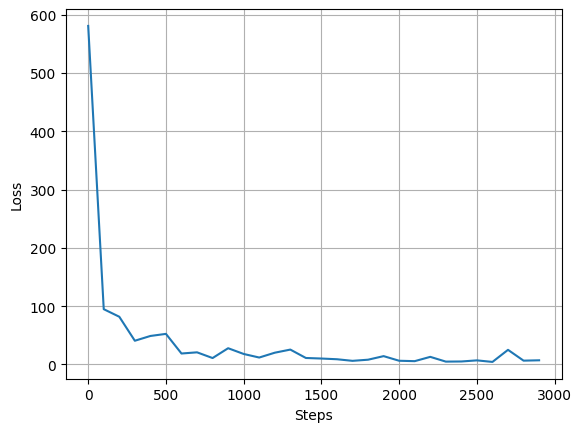

In [9]:
# Выведите графики зависимости изменения точности и потерь от шага
# Если все сделано правильно, то точность должна расти, а потери уменьшаться

plt.plot(range(0, training_steps, display_step), loss_history)
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid()
plt.show()

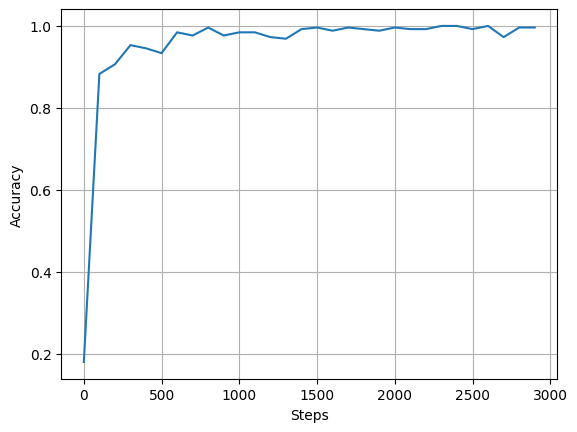

In [10]:
plt.plot(range(0, training_steps, display_step), accuracy_history)
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.grid()


In [11]:
# Вычислите точность обученной нейросети

y_pred_test = model(x_test)
acc = accuracy(y_pred = y_pred_test, y_true=y_test)
print(f' Accuracy : {acc}')

 Accuracy : 0.9779000282287598


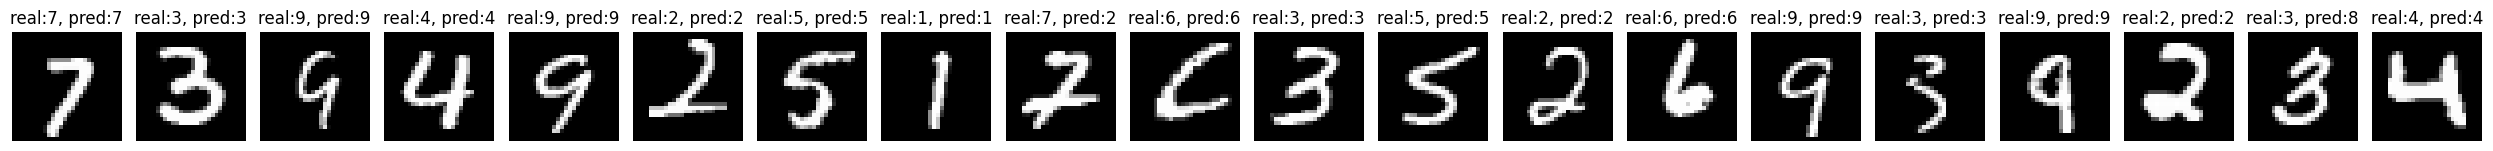

Error count: 2


In [39]:
# Протестируем обученную нейросеть на 10 изображениях. Из тестовой выборки возьмите 5
# случайных изображений и передайте их в нейронню сеть.
# Выведите изображение и выпишите рядом ответ нейросети.
# Сделайте вывод о том ошибается ли ваша нейронная сеть и если да, то как часто?
plt.figure(figsize=(25, 2))
err_cnt = 0
for i in range(20):
    random_ind = np.random.choice(len(x_test), 1, replace=False)
    image = x_test[random_ind]
    label = y_test[random_ind]
    pred = model(np.expand_dims(image, axis=0))
    predicted_label = tf.argmax(pred, axis=-1).numpy()[0]
    if label[0] != predicted_label[0]:
      err_cnt += 1
    image = image.reshape(28, 28)
    plt.subplot(1, 20, i+1)
    plt.imshow(image, cmap="gray")
    plt.axis('off')
    plt.title(f"real:{label[0]}, pred:{predicted_label[0]}")

plt.tight_layout()
plt.show()

print(f'Error count: {err_cnt}')

**Висновок**

Показник точності моделі 0.9779
На прикладі зараз є 2 помилки з 20, тобто точнічть 0,9, хоча до цього декілька разів грався і точність була 1
Тобто модель більш-меньш показує вправний результат

**Знаходимо матрицю помилок (confusion matrix)**

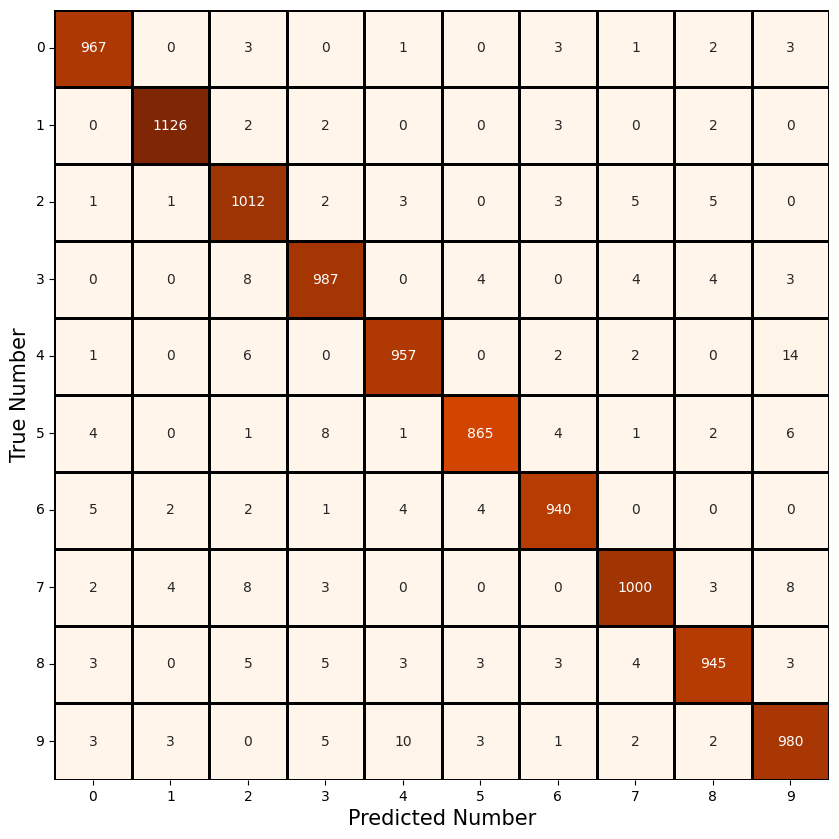

In [40]:
test_out = model(x_test).numpy()
y_pred_test = test_out.argmax(axis=1)
cm = confusion_matrix(y_test, y_pred_test)
df_confusion_matrix = pd.DataFrame(cm)

plt.figure(figsize=(10, 10))
sn.heatmap(df_confusion_matrix, fmt="d", annot=True, cbar=False, cmap="Oranges", linewidths=1, linecolor="black")
plt.xlabel("Predicted Number", fontsize=15)
plt.xticks(fontsize=10)
plt.ylabel("True Number", fontsize=15)
plt.yticks(fontsize=10, rotation=0);

In [41]:
ea = pd.DataFrame({"pred": y_pred_test, "y": y_test})
ea["equal"] = ea["pred"] == ea["y"]
ea[(ea["y"] == 6) & (ea["equal"] == False)]


,pred,y,equal
259,0,6,False
445,0,6,False
965,0,6,False
1014,5,6,False
1982,5,6,False
2118,0,6,False
2135,1,6,False
2654,1,6,False
3422,0,6,False
3520,4,6,False


**Приклади помилок**

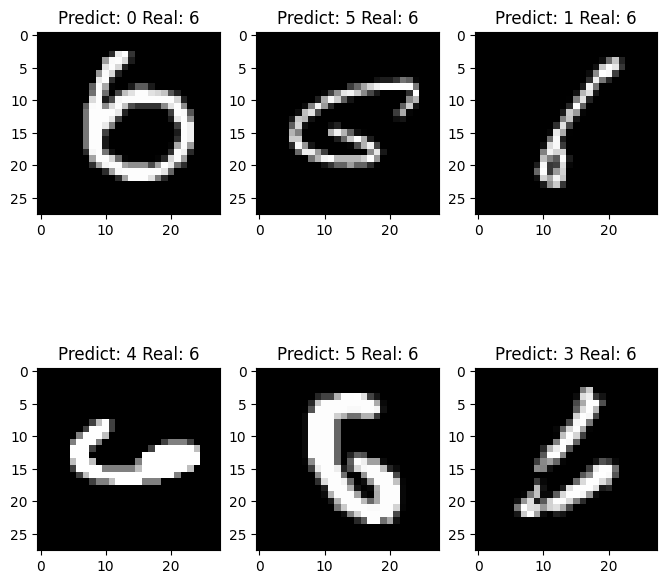

In [43]:
plt.figure(figsize=(8, 8))
index = [259, 1014, 2135, 3520, 4536, 9679]
for i, _x in enumerate(x_test[index], 1):
    plt.subplot(2, 3, i)
    plt.imshow(_x.reshape(28, 28), cmap="gray")
    plt.title(f"Predict: {y_pred_test[index[i - 1]]} Real: {y_test[index[i - 1]]}")